In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import csv
import itertools
import editdistance

import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import backend as K

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from google.colab import drive
drive.mount('/content/gdrive/')

%matplotlib inline

Mounted at /content/gdrive/


#### Import Data

In [2]:
data_path = '/content/gdrive/My Drive/Cardiovascular Disease/'
os.chdir(data_path)

In [ ]:
!unzip 'archive.zip'

Archive:  archive.zip
  inflating: cardio_train.csv        


In [3]:
df = pd.read_csv('cardio_train.csv', sep = ';')

In [4]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
X = df.drop(columns = 'id').values

In [6]:
X[0]

array([1.8393e+04, 2.0000e+00, 1.6800e+02, 6.2000e+01, 1.1000e+02,
       8.0000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00])

#### Split Data

In [7]:
neg_list = np.array([x[:-1] for x in X if x[-1] == 0])
pos_list = np.array([x[:-1] for x in X if x[-1] == 1])

max_length = min(len(neg_list), len(pos_list))

neg_list = neg_list[:max_length]
pos_list = pos_list[:max_length]

In [8]:
neg_train_list, neg_val_list, pos_train_list, pos_val_list = train_test_split(neg_list, pos_list, test_size = 0.2, random_state = 42)
neg_train_list, neg_test_list, pos_train_list, pos_test_list = train_test_split(neg_train_list, pos_train_list, test_size = 0.2, random_state = 42)

In [9]:
neg_train_df = pd.DataFrame(neg_train_list)
neg_val_df = pd.DataFrame(neg_val_list)
neg_test_df = pd.DataFrame(neg_test_list)

pos_train_df = pd.DataFrame(pos_train_list)
pos_val_df = pd.DataFrame(pos_val_list)
pos_test_df = pd.DataFrame(pos_test_list)

#### Save .txt files

In [10]:
neg_train_df.to_csv(path_or_buf = data_path + 'neg_train.txt', index=False, header=False, sep=' ', quoting = csv.QUOTE_NONE, escapechar = ' ')
neg_val_df.to_csv(path_or_buf = data_path + 'neg_val.txt', index=False, header=False, sep=' ', quoting = csv.QUOTE_NONE, escapechar = ' ')
neg_test_df.to_csv(path_or_buf = data_path + 'neg_test.txt', index=False, header=False, sep=' ', quoting = csv.QUOTE_NONE, escapechar = ' ')

In [11]:
pos_train_df.to_csv(path_or_buf = data_path + 'pos_train.txt', index=False, header=False, sep=' ', quoting = csv.QUOTE_NONE, escapechar = ' ')
pos_val_df.to_csv(path_or_buf = data_path + 'pos_val.txt', index=False, header=False, sep=' ', quoting = csv.QUOTE_NONE, escapechar = ' ')
pos_test_df.to_csv(path_or_buf = data_path + 'pos_test.txt', index=False, header=False, sep=' ', quoting = csv.QUOTE_NONE, escapechar = ' ')

#### Read .txt files

In [12]:
pos_train = pd.read_csv(data_path + 'pos_train.txt', header = None)
neg_train = pd.read_csv(data_path + 'neg_train.txt', header = None)

pos_train['label'] = [1 for i in range(pos_train.shape[0])]
neg_train['label'] = [0 for i in range(neg_train.shape[0])]

train = pd.concat([pos_train, neg_train]).reset_index()
train_batch = train.sample(frac=1, random_state=3)

X_train, y_train = train_batch[0], train_batch['label']

In [13]:
pos_val = pd.read_csv(data_path+'pos_val.txt', header = None)
neg_val =  pd.read_csv(data_path+'neg_val.txt', header = None)

pos_val['label'] = [1 for i in range(pos_val.shape[0])]
neg_val['label'] = [0 for i in range(neg_val.shape[0])]

val = pd.concat([pos_val, neg_val]).reset_index()
val_batch = val.sample(frac=1, random_state=3)

X_val, y_val = val_batch[0], val_batch['label']

In [14]:
pos_test = pd.read_csv(data_path+'pos_test.txt', header = None)
neg_test =  pd.read_csv(data_path+'neg_test.txt', header = None)

pos_test['label'] = [1 for i in range(pos_test.shape[0])]
neg_test['label'] = [0 for i in range(neg_test.shape[0])]

test = pd.concat([pos_test, neg_test]).reset_index()
test_batch = test.sample(frac=1, random_state=3)

X_test, y_test = test_batch[0], test_batch['label']

#### Data Processing

In [15]:
vocab_size = 1400
max_seq_length = 21

In [16]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [17]:
X_train_padded = sequence.pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')
X_val_padded = sequence.pad_sequences(X_val_sequences, maxlen=max_seq_length, padding='post')
X_test_padded = sequence.pad_sequences(X_test_sequences, maxlen=max_seq_length, padding='post')

In [18]:
X_train_padded.shape

(44772, 21)

In [19]:
X_val_padded.shape

(13992, 21)

In [20]:
X_val_padded[0]

array([ 1,  3,  1, 56,  1, 52,  1, 11,  1,  4,  1,  8,  1,  2,  1,  1,  1,
        1,  1,  2,  1], dtype=int32)

#### Model Implementation

In [21]:
es = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)

In [22]:
# Add Input layer
inputs = keras.Input(shape=(None,), dtype="int32")

# Add embedding layer
x = layers.Embedding(vocab_size, 128)(inputs)

# Add LSTM layers
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Add fully connected layer
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create Model
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         179200    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 376,961
Trainable params: 376,961
Non-trainable

In [23]:
model.compile(Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
history = model.fit(X_train_padded, y_train, epochs = 30, batch_size = 64, validation_data=(X_val_padded, y_val), callbacks = [es])

Epoch 1/30
700/700 [==============================] - 80s 103ms/step - loss: 0.5776 - accuracy: 0.7168 - val_loss: 0.5790 - val_accuracy: 0.7225
Epoch 2/30
700/700 [==============================] - 63s 90ms/step - loss: 0.5611 - accuracy: 0.7268 - val_loss: 0.5688 - val_accuracy: 0.7216
Epoch 3/30
700/700 [==============================] - 88s 125ms/step - loss: 0.5580 - accuracy: 0.7292 - val_loss: 0.5649 - val_accuracy: 0.7223
Epoch 4/30
700/700 [==============================] - 76s 109ms/step - loss: 0.5571 - accuracy: 0.7294 - val_loss: 0.5641 - val_accuracy: 0.7221


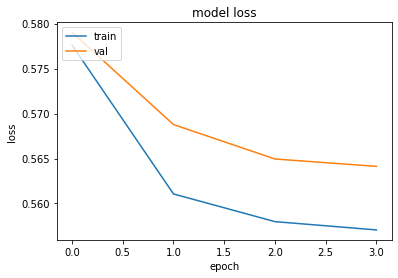

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

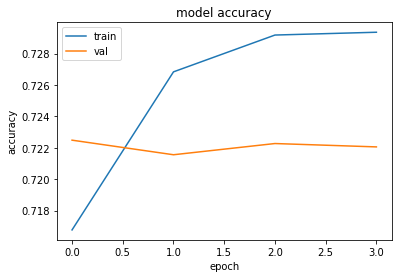

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Evaluating Model

In [27]:
# Taken from SKlearn website

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
y_pred = model.predict(X_test_padded)
y_pred = np.round(y_pred)

In [29]:
accuracy_score(y_test, y_pred)

0.7235125960335894

In [30]:
cm = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization
[[4496 1101]
 [1994 3603]]


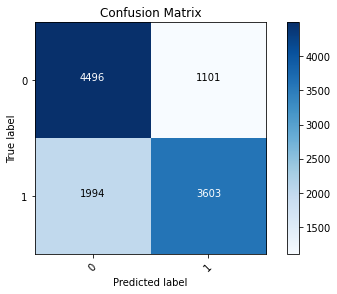

In [31]:
cm_plot_labels = [0, 1]
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [32]:
np.unique(y_pred, return_counts = True)

(array([0., 1.], dtype=float32), array([6490, 4704]))

##### Get negative predictions from LSTM

In [33]:
X_pred_negative = X_test_padded[y_pred.reshape(y_pred.shape[0]) == 0]
X_pred_negative

array([[1, 2, 1, ..., 1, 1, 1],
       [1, 2, 1, ..., 1, 2, 1],
       [1, 2, 1, ..., 1, 1, 1],
       ...,
       [1, 2, 1, ..., 1, 2, 1],
       [1, 3, 1, ..., 1, 2, 1],
       [1, 2, 1, ..., 1, 2, 1]], dtype=int32)

In [34]:
X_pred_negative.shape

(6490, 21)

In [35]:
# locate original data
pred_neg_data = val_batch.iloc[np.where(y_pred == 0)]
pred_pos_data = val_batch.iloc[np.where(y_pred == 1)]

In [36]:
# Convert negative tokens back to medical form
original_event_sequences = tokenizer.sequences_to_texts(X_pred_negative)

##### Modify negative predictions using Nearest Neighbour

In [37]:
# Model uses hamming distance
nn_model = NearestNeighbors(n_neighbors = 1, metric='hamming')

In [38]:
# Train data on true lables
X_target_label = X_train_padded[y_train == 1]

In [39]:
nn_model.fit(X_target_label)

NearestNeighbors(metric='hamming', n_neighbors=1)

In [55]:
# Find the closest neighbor as a counterfactual
closest = nn_model.kneighbors(X_pred_negative, return_distance = False)
trans_results_nn = X_target_label[closest[:, 0]]

trans_results_nn[0]

array([ 1,  2,  1, 18,  1,  7,  1,  5,  1,  4,  1,  2,  1,  2,  1,  1,  1,
        1,  1,  1,  1], dtype=int32)

##### Transform Results

In [56]:
trans_event_sequences = tokenizer.sequences_to_texts(trans_results_nn)

#### Comparison between fraction of valid CFs (i.e. successfully generated counterfactuals)

In [57]:
# Simple Results
y_pred = model.predict(X_test_padded)

In [71]:
fraction_success = np.sum(y_pred > 0.5)/y_pred.shape[0]
print(round(fraction_success, 4))

0.4202


In [72]:
# Counterfactual Results
y_pred_new = model.predict(trans_results_nn)

In [73]:
fraction_success_new = np.sum(y_pred_new > 0.5)/y_pred_new.shape[0]
print(round(fraction_success_new, 4))

0.0587


#### Local outlier factor (LOF score)
Code taken from Paper 3 github Repo

In [63]:
clf = LocalOutlierFactor(n_neighbors = 20, novelty = True, contamination = 0.1)
clf.fit(X_target_label)

LocalOutlierFactor(contamination=0.1, novelty=True)

In [66]:
# Simple Results
y_pred_test = clf.predict(X_test_padded)
n_error_test = y_pred_test[y_pred_test == -1].size

In [68]:
outlier_score_test = n_error_test/X_val_padded.shape[0]
outlier_score_test

0.08876500857632934

In [74]:
# Counterfactual Results
y_pred_test_new = clf.predict(trans_results_nn)
n_error_test_new = y_pred_test_new[y_pred_test_new == -1].size

outlier_score_test = n_error_test_new / y_pred_test_new.shape[0]
print(round(outlier_score_test, 4))

0.0875


#### BLEU-4 score (cumulative 4-gram BLEU score)
Code taken from Paper 3 Github Repo

In [75]:
# Define smoothing function
chencherry = SmoothingFunction()

# Define a function to get pairwise BLEU scores
def get_pairwise_bleu(original, transformed):
    # 'weights=[0.25, 0.25, 0.25, 0.25]' means that calculate 4-gram BLEU scores cumulatively
    results = [sentence_bleu(
        references=[pair[0].split()], 
        hypothesis=pair[1].split(), 
        weights=[0.25, 0.25, 0.25, 0.25], 
        smoothing_function=chencherry.method1) 
        for pair in zip(original, transformed)]
    
    return results

In [78]:
pairwise_bleu3 = get_pairwise_bleu(original_event_sequences, trans_event_sequences)
avg_bleu3 = sum(pairwise_bleu3)/y_pred_new.shape[0]
print(round(avg_bleu3, 4))

0.8958


#### Edit distance (Levenshtein)
Code Taken from Paper 3

In [80]:
def get_edit_distance(original, transformed):
    edit_distance_pair = [editdistance.eval(o, t) for o, t in zip(original.tolist(), transformed.tolist())]
    edit_score = np.mean(edit_distance_pair)
    
    return round(edit_score, 4)

In [81]:
get_edit_distance(X_test_padded, X_pred_negative)

4.8456

In [82]:
get_edit_distance(trans_results_nn, X_pred_negative)

0.8117

#### END